# Human Evaluation Results

The proposed notebook is used to compute the positive and negative results for each Dialogue Settings:

- Open Domain Dialogues (ODD) - DailDialog
- Knowledge-Grounded Dialogues (KGD) - Wizard of Wikipedia
- Task-Oriented Dialogues (TOD) - DSTC9 Track 1
- Question Answering (QA) - NarrativeQA

In [1]:
import json
from pathlib import Path
from typing import Any, Dict, List

import pandas as pd
import numpy as np


def filter_by_job_name(res: List[Dict[str, Any]], job_name: str) -> List[Dict[str, Any]]:
    return [r for r in res if r["json"]["job_name"] == job_name]


def filter_by_raters(res: List[Dict[str, Any]], raters: List[str]) -> List[Dict[str, Any]]:
    return [r for r in res if r["json"]["logs"]["worker_id"] in raters]

raters = None
ambiguous_samples = {}
ambiguous_negative_samples = {}
models_to_plot = [
    'mistral_prompt_gold',
    'mistral_ft_gold',
    'llama_prompt_gold',
    'llama_ft_gold',
]


with open("results.json") as f:
    res = json.load(f)

def get_annotation_results(relevant_res, annotation_results):
    for annotation in relevant_res:
        annotation = annotation["json"]
        sample_id = annotation["sample_id"]
        for task in annotation["task"]:
            for response_sample in task["response_samples"]:
                model = response_sample["response_sample_id"]
                answer = response_sample['annotations']
                task_id = task["id"]
                if task_id not in annotation_results:
                    annotation_results[task_id] = {}
                if sample_id not in annotation_results[task_id]:
                    annotation_results[task_id][sample_id] = {}
                if model not in annotation_results[task_id][sample_id]:
                    annotation_results[task_id][sample_id][model] = []

                annotation_results[task_id][sample_id][model].append(answer)
    return annotation_results


annotation_results = {}


Run one of the following cells to compute the results for a specific dialogue setting.

In [2]:
## DailyDialog

samples_to_eval_file = Path(f'../../llms4nlg/data/DailyDialog/samples_to_eval.json')

job_name = 'INLG24_DailyDialog_prolific'
raters = [
    '609d22a7186f9da021fb4a70',
    '652ac14b1834e1f6b28f6f52',
    '5dd6f8159c84d869a6929ba5',
    '63c80a427dfa1305502df5a8',
    '61199bc1d7d6343f9ba3f248'
]

relevant_res = filter_by_job_name(res, job_name)
relevant_res = filter_by_raters(relevant_res, raters)
annotation_results = get_annotation_results(relevant_res, annotation_results)

models_to_plot = [
    'mistral_prompt_none',
    'mistral_ft_none',
    'llama_prompt_none',
    'llama_ft_none',
]

no_reason_tasks = ['task_1']

In [2]:
## DSTC9
samples_to_eval_file = Path(f'../../llms4nlg/data/DSTC9/samples_to_eval.json')

raters = {
    0: ['5e08ec3ad52c7b1edf9a4ecd', '664764600a0d597872e76cfd', '665486f73c9f68e40025d1d6', '654d0b2e86ce84a548fcdc80', '5feef27983f6af185c8b3e4c'],
}

no_reason_tasks = ['task_1']

for job_id in range(4):
    job_name = f"INLG24_DSTC9_prolific_{job_id}"
    relevant_res = filter_by_job_name(res, job_name)
    if job_id in raters:
        relevant_res = filter_by_raters(relevant_res, raters[job_id])
    annotation_results = get_annotation_results(relevant_res, annotation_results)

In [2]:
## NQA

samples_to_eval_file = Path(f'../../llms4nlg/data/NarrativeQA/samples_to_eval.json')

raters = {
    3: ["5ec28db2622c500632dc95bc", "66472012c86df53542876f2a", "5ed7ca3a57af4a0aeb61d9cb", "6361bfe81e0da4a406b33f1e", "664fd415a2e4110498c36d1b"]
}

no_reason_tasks = ['task_1', 'task_3']

for job_id in range(4):
    job_name = f"INLG24_NQA_prolific_{job_id}"
    relevant_res = filter_by_job_name(res, job_name)
    if job_id in raters:
        relevant_res = filter_by_raters(relevant_res, raters[job_id])
    annotation_results = get_annotation_results(relevant_res, annotation_results)

In [2]:
## WoW

samples_to_eval_file = Path(f'../../llms4nlg/data/WizardOfWikipedia/samples_to_eval.json')

no_reason_tasks = [ "task_1" ]

for job_id in range(4):
    job_name = f"INLG24_WoW_prolific_{job_id}"
    relevant_res = filter_by_job_name(res, job_name)
    annotation_results = get_annotation_results(relevant_res, annotation_results)

## Process

In [ ]:
with open(samples_to_eval_file, 'r') as f:
    samples_to_eval = json.load(f)

identical_candidates = {}
for sample_id, sample in samples_to_eval.items():
    if 'idenitical_candidates' not in sample:
        continue
    for candidate in sample['idenitical_candidates'].keys():
        models = sample['idenitical_candidates'][candidate]
        if sample_id not in identical_candidates:
            identical_candidates[sample_id] = []
        identical_candidates[sample_id].append(models)

In [4]:
path = Path(f'../batch_generation/output/{job_name}')

batch_names = set()
original_samples = {}
models = {}
for dir in path.iterdir():
    for file in dir.iterdir():
        with open(file, 'r') as f:
            data = json.load(f)
        batch_names.add(data[0]["batch_id"])
        original_samples[data[0]["batch_id"]] = set()
        models[data[0]["batch_id"]] = {}
        for sample in data:
            original_samples[data[0]["batch_id"]].add(sample["sample_id"])
            models[data[0]["batch_id"]][sample["sample_id"]] = {i["response_sample_id"] for i in sample["task"][0]["response_samples"]}

shared_samples = set.intersection(*original_samples.values())

In [5]:
for sample_id, identical_models in identical_candidates.items():
    for models in identical_models:
        models = set(models)
        for task_id in annotation_results:
            annotated_models = set(annotation_results[task_id][sample_id].keys())
            copy_from = models.intersection(annotated_models)
            assert len(copy_from) == 1, f"More than one model annotated for {sample_id} in {task_id}"
            copy_from = copy_from.pop()
            copy_to = models - annotated_models
            for model in copy_to:
                annotation_results[task_id][sample_id][model] = annotation_results[task_id][sample_id][copy_from]
            

In [6]:
import pandas as pd

total_models = {}

for task_id, samples in annotation_results.items():
    assert len(samples) == 20, f"Missing samples for {task_id}"
    for sample_id, models in samples.items():
        if task_id not in total_models:
            total_models[task_id] = {}
        if sample_id not in total_models[task_id]:
            total_models[task_id][sample_id] = {}
        total_models[task_id][sample_id] = len(models)
            
for task_id, samples in total_models.items():
    display(pd.DataFrame(samples, index=[task_id]))

,dial_345_turn_5,dial_785_turn_5,dial_308_turn_5,dial_327_turn_6,dial_563_turn_6,dial_904_turn_5,dial_95_turn_5,dial_358_turn_6,dial_370_turn_5,dial_934_turn_6,dial_475_turn_6,dial_835_turn_6,dial_788_turn_6,dial_371_turn_6,dial_43_turn_5,dial_767_turn_5,dial_145_turn_5,dial_590_turn_6,dial_512_turn_5,dial_187_turn_6
task_1,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17


,dial_345_turn_5,dial_785_turn_5,dial_308_turn_5,dial_327_turn_6,dial_563_turn_6,dial_904_turn_5,dial_95_turn_5,dial_358_turn_6,dial_370_turn_5,dial_934_turn_6,dial_475_turn_6,dial_835_turn_6,dial_788_turn_6,dial_371_turn_6,dial_43_turn_5,dial_767_turn_5,dial_145_turn_5,dial_590_turn_6,dial_512_turn_5,dial_187_turn_6
task_2,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17


,dial_345_turn_5,dial_785_turn_5,dial_308_turn_5,dial_327_turn_6,dial_563_turn_6,dial_904_turn_5,dial_95_turn_5,dial_358_turn_6,dial_370_turn_5,dial_934_turn_6,dial_475_turn_6,dial_835_turn_6,dial_788_turn_6,dial_371_turn_6,dial_43_turn_5,dial_767_turn_5,dial_145_turn_5,dial_590_turn_6,dial_512_turn_5,dial_187_turn_6
task_3,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17


In [7]:
total_annotations = {}

for task_id, samples in annotation_results.items():
    for sample_id, models in samples.items():
        for model, annotations in models.items():
            if task_id not in total_annotations:
                total_annotations[task_id] = {}
            if model not in total_annotations[task_id]:
                total_annotations[task_id][model] = {}
            if sample_id not in total_annotations[task_id][model]:
                total_annotations[task_id][model][sample_id] = []
            total_annotations[task_id][model][sample_id].extend([answer['value'] for answer in annotations])

for task_id, samples in total_annotations.items():
    for model, samples in samples.items():
        total_annotations[task_id][model] = len(samples)

for task_id, annoations in total_annotations.items():
    display(pd.DataFrame(annoations, index=[task_id]))


,llama_prompt_retrieved_top-3,llama_ft_retrieved_top-3,llama_prompt_none,llama_ft_none,gt,mistral_ft_retrieved_top-3,mistral_ft_none,mistral_prompt_retrieved_top-3,mistral_prompt_none,mistral_prompt_gold,llama_ft_retrieved_top-1,llama_ft_gold,llama_prompt_gold,llama_prompt_retrieved_top-1,mistral_ft_gold,mistral_prompt_retrieved_top-1,mistral_ft_retrieved_top-1
task_1,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20


,llama_prompt_retrieved_top-3,llama_ft_retrieved_top-3,llama_prompt_none,llama_ft_none,gt,mistral_ft_retrieved_top-3,mistral_ft_none,mistral_prompt_retrieved_top-3,mistral_prompt_none,mistral_prompt_gold,llama_ft_retrieved_top-1,llama_ft_gold,llama_prompt_gold,llama_prompt_retrieved_top-1,mistral_ft_gold,mistral_prompt_retrieved_top-1,mistral_ft_retrieved_top-1
task_2,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20


,llama_prompt_retrieved_top-3,llama_ft_retrieved_top-3,llama_prompt_none,llama_ft_none,gt,mistral_ft_retrieved_top-3,mistral_ft_none,mistral_prompt_retrieved_top-3,mistral_prompt_none,mistral_prompt_gold,llama_ft_retrieved_top-1,llama_ft_gold,llama_prompt_gold,llama_prompt_retrieved_top-1,mistral_ft_gold,mistral_prompt_retrieved_top-1,mistral_ft_retrieved_top-1
task_3,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20


In [8]:
from collections import Counter
results = {}

for task_id, samples in annotation_results.items():
    for sample_id, models in samples.items():
        for model, annotations in models.items():
            if task_id not in results:
                results[task_id] = {}
            if model not in results[task_id]:
                results[task_id][model] = {}
            if sample_id not in results[task_id][model]:
                results[task_id][model][sample_id] = Counter()
            results[task_id][model][sample_id].update([answer['value'] for answer in annotations])

## Positive Results

In [9]:
from copy import deepcopy

majority_votings = deepcopy(results)
for task_id, models in results.items():
    for model, samples in models.items():
        for sample_id, answers in samples.items():
            if len(answers) > 1:
                if answers.most_common(1)[0][1] > sum(answers.values()) / 2:
                    majority_votings[task_id][model][sample_id] = answers.most_common(1)[0][0]
                else:
                    majority_votings[task_id][model][sample_id] = "I don't know"
            else:
                majority_votings[task_id][model][sample_id] = answers.most_common(1)[0][0]

In [10]:
results_per_task_per_model = {}

for task, models in majority_votings.items():
    for model, samples in models.items():
        answers = Counter()
        for _, answer in samples.items():
            answers.update([answer])
        if task not in results_per_task_per_model:
            results_per_task_per_model[task] = {}
        results_per_task_per_model[task][model] = {k: v/sum(answers.values())*100 for k, v in answers.items()}
        results_per_task_per_model[task][model]["total"] = sum(answers.values())

In [11]:
map_models = {
    "gt": "Ground-Truth",
    'mistral_prompt_none': 'M ICL Baseline',
    'mistral_prompt_retrieved_top-1': 'M ICL Top-1',
    'mistral_prompt_retrieved_top-3': 'M ICL Top-3',
    'mistral_prompt_gold': 'M ICL Gold',
    'mistral_ft_none': 'M FT Baseline',
    'mistral_ft_retrieved_top-1': 'M FT Top-1',
    'mistral_ft_retrieved_top-3': 'M FT Top-3',
    'mistral_ft_gold': 'M FT Gold',
    'llama_prompt_none': 'L ICL Baseline',
    'llama_prompt_retrieved_top-1': 'L ICL Top-1',
    'llama_prompt_retrieved_top-3': 'L ICL Top-3',
    'llama_prompt_gold': 'L ICL Gold',
    'llama_ft_none': 'L FT Baseline',
    'llama_ft_retrieved_top-1': 'L FT Top-1',
    'llama_ft_retrieved_top-3': 'L FT Top-3',
    'llama_ft_gold': 'L FT Gold',
}

for task, models in results_per_task_per_model.items():
    models_copy = {}
    for model, result in sorted(models.items()):
        if "top-1" in model:
            continue
        models_copy[map_models[model]] = result

    display(pd.DataFrame.from_dict(models_copy).round(2))

,Ground-Truth,L FT Gold,L FT Baseline,L FT Top-3,L ICL Gold,L ICL Baseline,L ICL Top-3,M FT Gold,M FT Baseline,M FT Top-3,M ICL Gold,M ICL Baseline,M ICL Top-3
Correct,70.0,85.0,90.0,90.0,80.0,80.0,80.0,70.0,85.0,75.0,85.0,70.0,55.0
Not Correct,20.0,15.0,10.0,10.0,20.0,20.0,20.0,25.0,15.0,25.0,15.0,30.0,45.0
I don't know,10.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
total,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0


,Ground-Truth,L FT Gold,L FT Baseline,L FT Top-3,L ICL Gold,L ICL Baseline,L ICL Top-3,M FT Gold,M FT Baseline,M FT Top-3,M ICL Gold,M ICL Baseline,M ICL Top-3
Approriate,85.0,65.0,65.0,80.0,85.0,70.0,75.0,65.0,80.0,85.0,70.0,85.0,65.0
I don't know,10.0,10.0,10.0,10.0,5.0,25.0,20.0,10.0,NaN,NaN,5.0,5.0,5.0
Not Appropriate,5.0,25.0,25.0,10.0,10.0,5.0,5.0,25.0,20.0,15.0,25.0,10.0,30.0
total,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0


,Ground-Truth,L FT Gold,L FT Baseline,L FT Top-3,L ICL Gold,L ICL Baseline,L ICL Top-3,M FT Gold,M FT Baseline,M FT Top-3,M ICL Gold,M ICL Baseline,M ICL Top-3
Contextualized,80.0,80.0,60.0,65.0,90.0,70.0,75.0,80.0,90.0,95.0,90.0,80.0,75.0
I don't know,15.0,5.0,15.0,20.0,5.0,15.0,20.0,5.0,NaN,NaN,5.0,NaN,NaN
Not Contextualized,5.0,15.0,25.0,15.0,5.0,15.0,5.0,15.0,10.0,5.0,5.0,20.0,25.0
total,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0


## Negative Results

In [12]:
non_negatives_per_task_per_model = {}

for task, models in majority_votings.items():
    for model, samples in models.items():
        answers = Counter()
        for _, answer in samples.items():
            answers.update([answer])
        if task not in non_negatives_per_task_per_model:
            non_negatives_per_task_per_model[task] = {}
        non_negatives_per_task_per_model[task][model] = sum([v for k, v in answers.items() if ('not ' not in k.lower())])

In [13]:
from collections import Counter
results = {}

for task_id, samples in annotation_results.items():
    for sample_id, models in samples.items():
        for model, annotations in models.items():
            if 'Not ' not in majority_votings[task_id][model][sample_id]:
                continue
            if task_id not in results:
                results[task_id] = {}
            if model not in results[task_id]:
                results[task_id][model] = {}
            if sample_id not in results[task_id][model]:
                results[task_id][model][sample_id] = Counter()
            results[task_id][model][sample_id].update([answer['reason'] for answer in annotations if ('not' in answer['value'].lower()) and ('reason' in answer)])

In [14]:
from copy import deepcopy

negative_majority_votings = deepcopy(results)
for task_id, models in results.items():
    if task_id in no_reason_tasks:
        continue
    for model, samples in models.items():
        for sample_id, answers in samples.items():
            if len(answers) > 1:
                if answers.most_common(1)[0][1] > sum(answers.values()) / 2:
                    negative_majority_votings[task_id][model][sample_id] = answers.most_common(1)[0][0]
                else:
                    negative_majority_votings[task_id][model][sample_id] = "other"
            elif len(answers) == 0:
                assert 'not ' not in majority_votings[task_id][model][sample_id].lower(), f"Majority voting failed for {task_id} {model} {sample_id}: {answers}"
                del negative_majority_votings[task_id][model][sample_id]
            else:
                negative_majority_votings[task_id][model][sample_id] = answers.most_common(1)[0][0]

In [15]:
results = {}

for task_id, models in negative_majority_votings.items():
    if task_id in no_reason_tasks:
        continue
    for model, samples in models.items():
        for sample_id, reasons in samples.items():
            if task_id not in results:
                results[task_id] = {}
            if model not in results[task_id]:
                results[task_id][model] = Counter()
            
            results[task_id][model].update([reasons])
        

In [16]:
filtered_results = deepcopy(results)

for task_id, models in results.items():
    for model, reasons in models.items():
        if model not in models_to_plot:
            del filtered_results[task_id][model]

In [17]:
not_correct_reasons = {}
for task, models in filtered_results.items():
    for model, reasons in models.items():
        for reason, count in reasons.items():
            if 'other' not in reason.lower():
                if reason not in not_correct_reasons:
                    not_correct_reasons[reason] = {}
                n_non_negatives = non_negatives_per_task_per_model[task][model]
                assert sum(reasons.values()) + n_non_negatives == 20, f"Sum of reasons is not 20 for {task} {model} {reason}: {sum(reasons.values()) + n_non_negatives}"
                not_correct_reasons[reason][model] = count / (sum(reasons.values()) + n_non_negatives) * 100
                

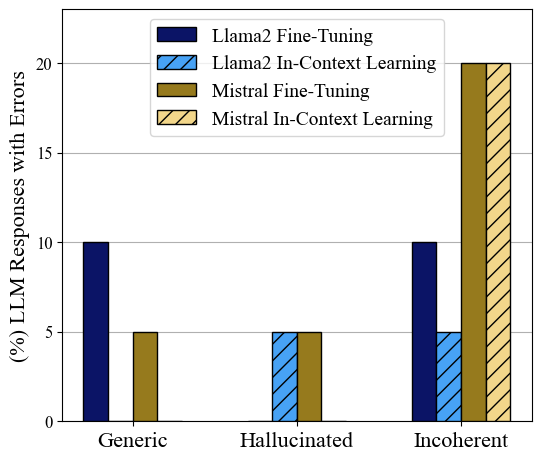

In [18]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"

map_reasons = {
    "incoherent": "Incoherent",
    "genericness": "Generic",
    "hallucination": "Hallucinated",
    'unhelpful': 'Unhelpful',
}
map_models = {
    'mistral_prompt_none': 'Mistral In-Context Learning',
    'mistral_prompt_retrieved_top-1': 'Mistral In-Context Learning',
    'mistral_prompt_retrieved_top-3': 'Mistral In-Context Learning',
    'mistral_prompt_gold': 'Mistral In-Context Learning',
    'mistral_ft_none': 'Mistral Fine-Tuning',
    'mistral_ft_retrieved_top-1': 'Mistral Fine-Tuning',
    'mistral_ft_retrieved_top-3': 'Mistral Fine-Tuning',
    'mistral_ft_gold': 'Mistral Fine-Tuning',
    'llama_prompt_none': 'Llama2 In-Context Learning',
    'llama_prompt_retrieved_top-1': 'Llama2 In-Context Learning',
    'llama_prompt_retrieved_top-3': 'Llama2 In-Context Learning',
    'llama_prompt_gold': 'Llama2 In-Context Learning',
    'llama_ft_none': 'Llama2 Fine-Tuning',
    'llama_ft_retrieved_top-1': 'Llama2 Fine-Tuning',
    'llama_ft_retrieved_top-3': 'Llama2 Fine-Tuning',
    'llama_ft_gold': 'Llama2 Fine-Tuning',
}
reasons = sorted(not_correct_reasons.keys())
models = sorted(set(y for x in not_correct_reasons.values() for y in x.keys()))
model_errors = {
    map_models[model] : [not_correct_reasons[reason][model] if model in not_correct_reasons[reason] else 0.0 for reason in reasons] for model in models
}
reasons = [map_reasons[reason] for reason in reasons]

x = np.arange(len(reasons))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(5.3,4.5))

# Define colormap
colors = {
    'Mistral ICL': '#F2D68A',
    'Mistral FT': '#967A1D',
    'Llama-2 ICL': '#47A2F5',
    'Llama-2 FT': '#0B1466',
}

for attribute, measurement in model_errors.items():
    offset = width * multiplier
    base_color = 'lightgrey'  # Default color
    if 'In-Context' in attribute:
        if 'Mistral' in attribute:
            base_color = colors['Mistral ICL']
        elif 'Llama2' in attribute:
            base_color = colors['Llama-2 ICL']
    elif 'Fine-Tuning' in attribute:
        if 'Mistral' in attribute:
            base_color = colors['Mistral FT']
        elif 'Llama2' in attribute:
            base_color = colors['Llama-2 FT']
    
    rects = ax.bar(x + offset - 0.075, measurement, width, label=attribute, color=base_color, edgecolor='black', zorder=3, align='center', hatch='//' if 'In-Context' in attribute else '')
    multiplier += 1

ax.set_ylabel('(%) LLM Responses with Errors', fontsize=16)
ax.set_xticks(x + width, reasons, fontsize=16)
#ax.legend(loc='upper center', ncols=1, bbox_to_anchor=(0.5, 1.45), fontsize=14)
ax.legend(loc='upper center', ncols=1, fontsize=14)
ax.grid(axis='y')
#plt.yticks(range(0, 60, 10), fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 23)
plt.savefig(f'{job_name.split("_prolific")[0]}_errors.svg', bbox_inches='tight')
plt.show()